In [23]:
import cv2 as cv
x = cv.imread('4.jpg')

In [118]:
import torchvision.transforms as transforms
from PIL import Image,ImageOps

img = Image.open('4.jpg').convert('RGB')
gray_image = ImageOps.grayscale(img)

resize = transforms.Resize([img.size[0],img.size[0]])
img = resize(img)
to_tensor = transforms.ToTensor()

tensor = to_tensor(img)
tensor = tensor.unsqueeze(0)

In [119]:
import math
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F


class Morphology(nn.Module):
    '''
    Base class for morpholigical operators 
    For now, only supports stride=1, dilation=1, kernel_size H==W, and padding='same'.
    '''
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        '''
        in_channels: scalar
        out_channels: scalar, the number of the morphological neure. 
        kernel_size: scalar, the spatial size of the morphological neure.
        soft_max: bool, using the soft max rather the torch.max(), ref: Dense Morphological Networks: An Universal Function Approximator (Mondal et al. (2019)).
        beta: scalar, used by soft_max.
        type: str, dilation2d or erosion2d.
        '''
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
        self.unfold = nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

    def forward(self, x):
        '''
        x: tensor of shape (B,C,H,W)
        '''
        # padding
        x = fixed_padding(x, self.kernel_size, dilation=1)
        
        # unfold
        x = self.unfold(x)  # (B, Cin*kH*kW, L), where L is the numbers of patches
        x = x.unsqueeze(1)  # (B, 1, Cin*kH*kW, L)
        L = x.size(-1)
        L_sqrt = int(math.sqrt(L))

        # erosion
        weight = self.weight.view(self.out_channels, -1) # (Cout, Cin*kH*kW)
        weight = weight.unsqueeze(0).unsqueeze(-1)  # (1, Cout, Cin*kH*kW, 1)

        if self.type == 'erosion2d':
            x = weight - x # (B, Cout, Cin*kH*kW, L)
        elif self.type == 'dilation2d':
            x = weight + x # (B, Cout, Cin*kH*kW, L)
        else:
            raise ValueError
        
        if not self.soft_max:
            x, _ = torch.max(x, dim=2, keepdim=False) # (B, Cout, L)
        else:
            x = torch.logsumexp(x*self.beta, dim=2, keepdim=False) / self.beta # (B, Cout, L)

        if self.type == 'erosion2d':
            x = -1 * x

        # instead of fold, we use view to avoid copy
        x = x.view(-1, self.out_channels, L_sqrt, L_sqrt)  # (B, Cout, L/2, L/2)

        return x 

class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')

class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')



def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs
    
    
if __name__ == '__main__':

    e=Erosion2d(3,4,3,soft_max=False)
    y=e(tensor)

In [120]:
from torchvision.utils import save_image

img1 = y[0]
save_image(img1, 'img1.png')

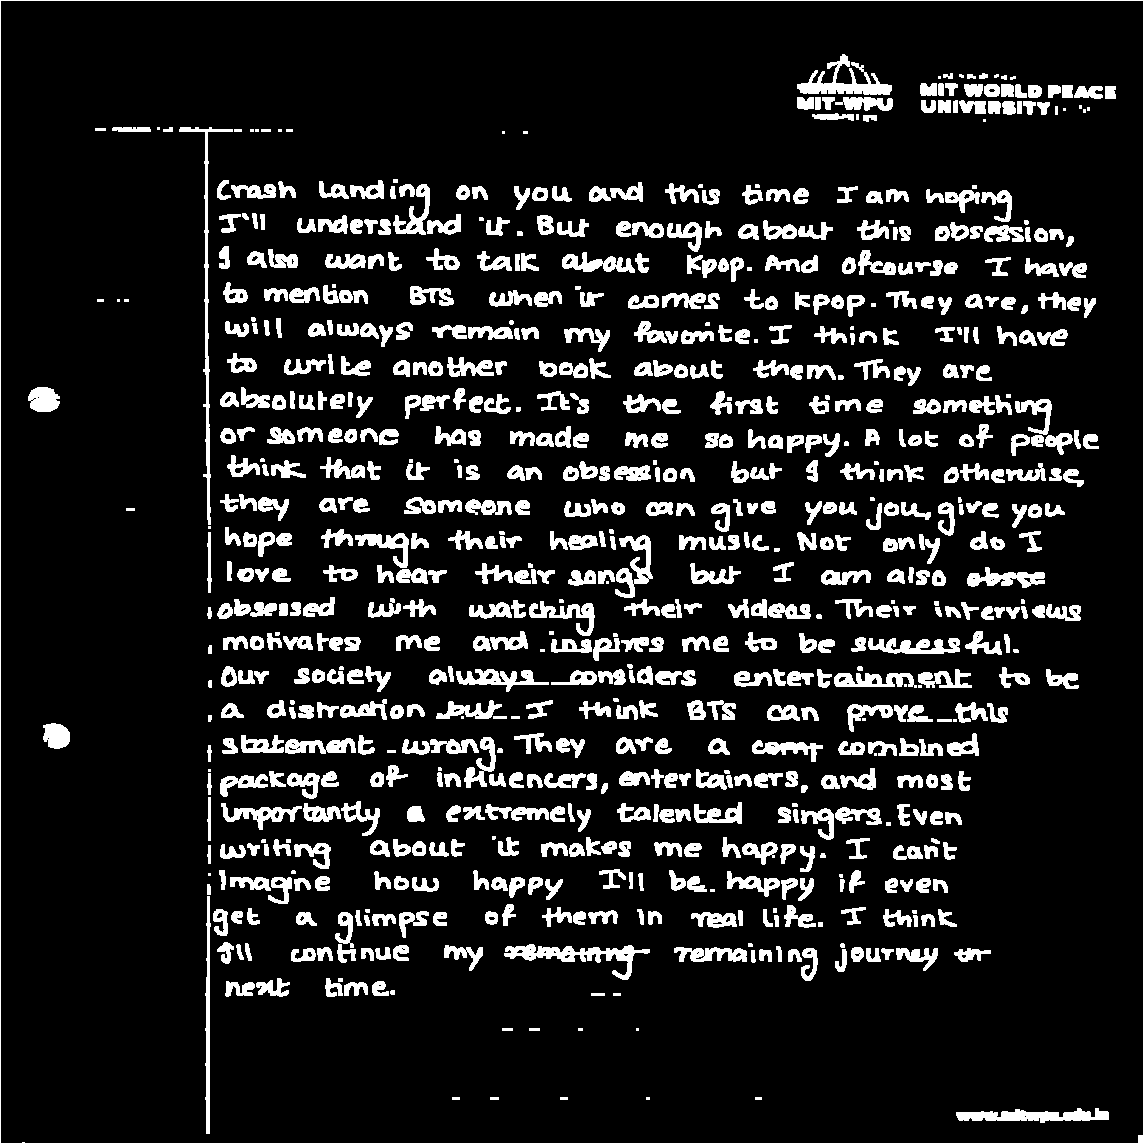

In [124]:
import numpy as np
from google.colab.patches import cv2_imshow
image = cv.imread('img1.png') 
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
bw = cv.threshold(gray, 0, 255,cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
cv2_imshow(bw) 